Programming for Data Science

# Introduction
In this project, I will analyse a predictive maintenance dataset. The dataset contains data on the machine usage, whether or not the machine failed and the failure type. 

The dataset is a synthetic dataset created by the author Stephan Matzka. It was published together with a paper in an IEEE conference ("2020 Third International Conference on Artificial Intelligence for Industries (AI4I)"). 

The paper is called "Explainable Artificial Intelligence for Predictive Maintenance Applications" and can be accessed under the following link. 
https://ieeexplore.ieee.org/document/9253083

Real datasets containing manufacturing information are hard to obtain, since most companies do not publish confidential production data. However, the author assures that the dataset is realistic and reflects real predictive maintenance data as it would exist in the industry.  

The goals of the project are as follows: 

* Prepare the dataset for classification 
* Split the dataset into training and testing set and resample the training set to deal with imbalance
* Predict the following two targets by implementing and tuning different classification models: 
    * Does the machine fail or not? (Binary Classification Problem)
    * Which failure type occurs? (Multiple Classification Problem) 
* Determine which model is most successful. 

The goal of the paper, in contrast to this project, is not to find some kind of best classifier. Instead, the goal is to find an explainable model that is understandable by humans. According to the author, this is essential for users to trust the results of the model. Therefore, he uses a *bagged trees ensemble classifier*. This classifier is based on multiple decision trees. Each decision tree is based on an independent replica of input data.

I, on the other hand, will use and tune the following classifiers: 
* Decision Tree Classifier
* Random Forest Classifier 
* Naive Bayes Classifier 
* K-Nearest Neighbors Classifier 

To avoid confusion between the binary and the multiple classification problem, I indicate which problem it is in every text block and used distinct colors in plots (binary: lines are colored orange, multiple: lines are colored pink). 

One final remark for the reader is that the obtained results of the classifiers might vary slightly with each run of the notebook. So if in some places the text does not fit the results perfectly, this is because one of the previous runs resulted in slightly varied values. 

# Data Exploration
## Importing libraries

In [1]:
# Basic libraries for analysis and plotting: Numpy, Pandas, Pyplot, Seaborn
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
sn.set_theme(style="whitegrid")

# Preparation of training and testing set
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Tuning 
from sklearn.model_selection import RandomizedSearchCV

# Metrics for evaluating the models
from sklearn.metrics import f1_score, recall_score, precision_recall_curve

## Importing the dataset

The original dataset can be downloaded from the UCI Machine Learning repository using the following link: 
https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset.

Additionally, there is a slightly different version of the dataset available on Kaggle: 
https://www.kaggle.com/shivamb/machine-predictive-maintenance-classification.

In the following, I will compare both versions. 

Both versions are provided as a csv-file which can be read using pandas.

In [2]:
maintenance_df_kaggle = pd.read_csv('predictive_maintenance.csv')
maintenance_df_kaggle.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [3]:
maintenance_df_uci = pd.read_csv('ai4i2020.csv')
maintenance_df_uci.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


From a quick view, the data in the first nine columns looks the same. Both datasets contain a Unique ID (UDI), six features describing the machine and a target displaying whether the machine fails or not. 

The paper gives some more information on the features. For more information on how the synthetic features were created, please refer to the paper (link above). 
1. **product ID**: The product ID contains a letter indicating the product quality (L = low, M = medium, H = high) and a variant-specific serial number.  
2. **air temperature**: The air temperature in Kelvin [K]. 
3. **process temperature**: The process temperature (in the machine) in Kelvin [K].
4. **rotational speed**: Rotational speed in revolutions per minute [rpm]. 
5. **torque**: The torque value in Newton-metre [Nm]. 
6. **tool wear**: The tool wear time in minutes. 

These features represent typical physical stresses that are put on a mechanical machine. An example in this case could be a lathe (a machine that rotates a workpiece and cuts it), because there are the features "rotational speed", "torque" and "tool wear". Of course, modern machines also contain electronic parts which can fail. However, I consider the physical stress a good (and probably simpler) starting point for predictive maintenance, since the relation between the mechanical load and the failure might be more straighforward. 

The possible values for the target "Failure Type" are **tool wear failure** (TWF), **heat dissipation failure** (HDF), **power failure** (PWF), **overstrain failure** (OSF) and **random failures** (RNF). They are named after the physical stress(es) that were used to create ("cause") the failure type. 

Let's see whether the assumption that both datasets are the same for the first nine features is true. 

In [4]:
maintenance_df_kaggle = maintenance_df_kaggle.rename(columns={"Target":"Machine failure"})
maintenance_df_kaggle.loc[:, 'UDI':'Machine failure'].equals(maintenance_df_uci.loc[:, 'UDI':'Machine failure'])

True

This proves that the two dataframes only differ in the display of the failure type. The Kaggle version contains only one feature for the failure type, whereas the UCI version contains one feature per failure type. 
Let's see whether the information in the two datasets is equal. 

In [5]:
maintenance_df_uci['number_of_failures'] = maintenance_df_uci.loc[:, 'TWF':'RNF'].sum(axis=1)
maintenance_df_uci['number_of_failures'].unique()

array([0, 1, 2, 3], dtype=int64)

The code above shows that there are machines that have multiple failures. Since there is only failure type for each machine in the Kaggle version, the versions are not equal. The Kaggle dataset misses information for the machines that experienced a multiple failure. I will check for how many machines this applies. 

In [6]:
maintenance_df_uci[maintenance_df_uci['number_of_failures']>1]['UDI'].count()

24

Out of 10000 machines, there are only 24 for which information is lost in the Kaggle version. A visual inspection of the datasets shows that the Kaggle version simply uses the leftmost failure type in the UCI version. That means, if there is a Tool Wear Failure and a Heat Dissipation Failure in the UCI version, for instance, the Kaggle version contains only the Tool Wear Failure. However, the Kaggle version is better for using classification models, since there are only two target features in contrast to six. Therefore, I will go on with the Kaggle version. I will import the data again to make sure all previous changes are reverted.

In [7]:
maintenance_df = pd.read_csv('predictive_maintenance.csv')
maintenance_df = maintenance_df.rename(columns={"Target":"Machine failure"})

## Exploratory Data Analysis


In [8]:
maintenance_df.info()
maintenance_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
Failure Type               0
dtype: int64

The dataset contains 10.000 rows. 
No column contains missing values. This was expected since it is a synthetic dataset. 

Furthermore, I will check whether the Product ID and / or the UDI is unique (which it should be). 

In [9]:
print(maintenance_df['UDI'].unique().size)
print(maintenance_df['Product ID'].unique().size)

10000
10000


Both IDs contain 10000 distinct values for 10000 rows. Therefore, the UDI can be set as a unique identifier.

In [10]:
maintenance_df = maintenance_df.set_index('UDI')

Furthermore, I will check whether the two targets "Machine Failure" and "Failure Type" are consistent. To be concrete, if the "Machine Failure" is 0 the "Failure Type" should be 1 and vice versa. 

In [11]:
maintenance_df["aligned"] = ((maintenance_df["Failure Type"]=="No Failure") & (maintenance_df["Machine failure"]==0))|(maintenance_df["Failure Type"]!="No Failure") & (maintenance_df["Machine failure"]!=0)
print("Amount of inconsistent datapoints:", maintenance_df[maintenance_df["aligned"]==False]["Product ID"].count())
maintenance_df[maintenance_df["aligned"]==False].head()


Amount of inconsistent datapoints: 27


,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure Type,aligned
UDI,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,0,Random Failures,False
1303,L48482,L,298.6,309.8,1505,45.7,144,0,Random Failures,False
1438,H30851,H,298.8,309.9,1439,45.2,40,1,No Failure,False
1749,H31162,H,298.4,307.7,1626,31.1,166,0,Random Failures,False
2073,L49252,L,299.6,309.5,1570,35.5,189,0,Random Failures,False


As you can see, there are 27 data points that are not consistent. A quick visual check showed that it is the same for the UCI version of the dataset. 
Since according to the paper, the "Machine Failure" target was computed from the "Failure Type" target when creating the synthetic dataset, I will take the "Failure Type" target as the truth and manipulate the dataset accordingly. 

In [12]:
#maintenance_df.loc[maintenance_df["aligned"]==False, "Machine failure"] = (maintenance_df.loc[maintenance_df["aligned"]==False, "Machine failure"]-1)*(-1)
index = maintenance_df[maintenance_df["aligned"]==False].index
maintenance_df.iloc[index-1,7]=(maintenance_df.iloc[index-1,7]-1)*(-1)
maintenance_df[maintenance_df["aligned"]==False].head()

,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,Failure Type,aligned
UDI,,,,,,,,,,
1222,M16081,M,297.0,308.3,1399,46.4,132,1,Random Failures,False
1303,L48482,L,298.6,309.8,1505,45.7,144,1,Random Failures,False
1438,H30851,H,298.8,309.9,1439,45.2,40,0,No Failure,False
1749,H31162,H,298.4,307.7,1626,31.1,166,1,Random Failures,False
2073,L49252,L,299.6,309.5,1570,35.5,189,1,Random Failures,False


In [13]:
maintenance_df.drop(columns=["aligned"], inplace = True)

As you can see from the first few datapoints, the "Machine Failure" and the "Failure Type" are now consistent. 

In the following, I will explore the features using Graphs.

### Product Quality
The following barchart shows how many products of different qualities are produced by the 10.000 machines.

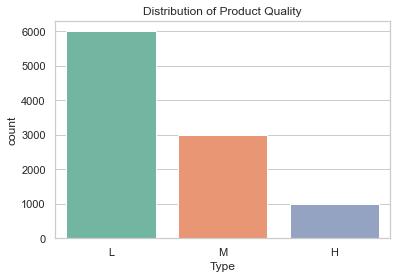

In [14]:
fig, ax = plt.subplots()
sn.set_palette(sn.color_palette("Set2"))
ax.set(title = "Distribution of Product Quality")
sn.countplot(data = maintenance_df, x="Type", order = ["L", "M", "H"])
plt.show()

60 % of the machines produce products with a low quality, 30 % products with a medium quality and 10 % high-quality products. The even numbers are, of course, due to the fact that it is a synthetic dataset. 

### Air temperature
The following histogram plots the distribution of air temperatures.

Minimum: 295.3
Maximum: 304.5
Mean: 300.00492999999875
Standard Deviation: 2.0002586829157574


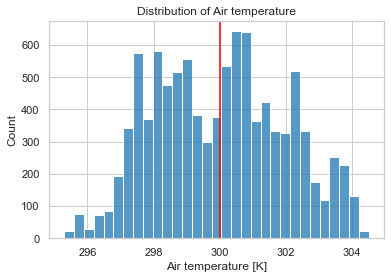

In [15]:
fig, ax = plt.subplots()
sn.set_palette(sn.color_palette("tab10"))
ax.set(title = "Distribution of Air temperature")
sn.histplot(data = maintenance_df,x="Air temperature [K]")
plt.axvline(x=maintenance_df["Air temperature [K]"].mean(), color = "red")
print("Minimum:", maintenance_df["Air temperature [K]"].min())
print("Maximum:", maintenance_df["Air temperature [K]"].max())
print("Mean:", maintenance_df["Air temperature [K]"].mean())
print("Standard Deviation:", maintenance_df["Air temperature [K]"].std())

The air temperature lies between 295.3 Kelvin (22.15 ° Celsius) and 304.5 Kelvin (31.35 ° Celsius). The average air temperature is 300.0 Kelvin (26.9 ° Celsius).  

### Process Temperature

Minimum: 305.7
Maximum: 313.8
Mean: 310.00555999999995
Standard Deviation: 1.4837342191657419


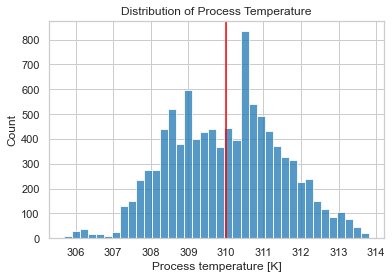

In [16]:
fig, ax = plt.subplots()
ax.set(title = "Distribution of Process Temperature")
sn.histplot(data = maintenance_df,x="Process temperature [K]")
plt.axvline(x=maintenance_df["Process temperature [K]"].mean(), color = "red")
print("Minimum:", maintenance_df["Process temperature [K]"].min())
print("Maximum:", maintenance_df["Process temperature [K]"].max())
print("Mean:", maintenance_df["Process temperature [K]"].mean())
print("Standard Deviation:", maintenance_df["Process temperature [K]"].std())

The process temperature ranges from 305.7 K (32.6 ° C) to 313.8 K (39.8 ° C). The average process temperature is 310.0 Kelvin. Therefore, the average lies 10 Kelvin / ° C above the average of the air temperature. 

### Rotational Speed
The following Histogram shows the distribution of the rotational speed (measured in revolutions per minute). 

Minimum: 1168
Maximum: 2886
Mean: 1538.7761
Standard deviation: 179.28409591342628


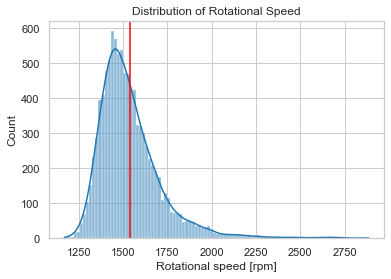

In [17]:
fig, ax = plt.subplots()
ax.set(title = "Distribution of Rotational Speed")
sn.histplot(data = maintenance_df,x="Rotational speed [rpm]", kde = True)
plt.axvline(x=maintenance_df["Rotational speed [rpm]"].mean(), color = "red")
print("Minimum:", maintenance_df["Rotational speed [rpm]"].min())
print("Maximum:", maintenance_df["Rotational speed [rpm]"].max())
print("Mean:", maintenance_df["Rotational speed [rpm]"].mean())
print("Standard deviation:", maintenance_df["Rotational speed [rpm]"].std())

As one can see from the gaussian kernel density estimate and the average, it is a distribution with a positive skewness (the right "tail" of the distribution is longer, the majority of datapoints is concentrated at lower rotational speeds). 

The following boxplot shows this even more clearly: 

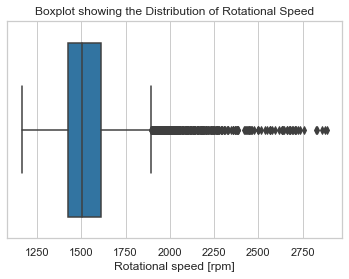

In [18]:
fig, ax = plt.subplots()
ax.set(title = "Boxplot showing the Distribution of Rotational Speed")
sn.boxplot(data = maintenance_df,x="Rotational speed [rpm]")
plt.show()

For higher rotational speeds, there are a lot of outliers that are right of the whisker. 
The whisker is calculated by adding 1,5 times the size of the "box" (the interquartil distance) to the 75th percentil (the right side of the box).

### Torque 
The torque is the rotational force and is measured in Newton-metres. If the object is not fixed, the torque results in the rotation of the object. The following histogram shows the distribution of the torque values. 

Minimum: 3.8
Maximum: 76.6
Mean: 39.986909999999995
Standard deviation: 9.968933725121401


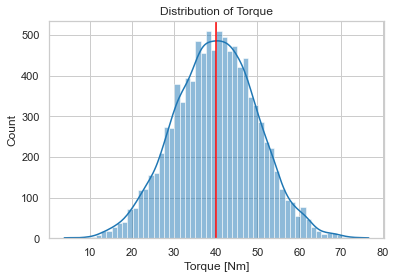

In [19]:
fig, ax = plt.subplots()
ax.set(title = "Distribution of Torque")
sn.histplot(data = maintenance_df,x="Torque [Nm]", kde = True)
plt.axvline(x=maintenance_df["Torque [Nm]"].mean(), color = "red")
print("Minimum:", maintenance_df["Torque [Nm]"].min())
print("Maximum:", maintenance_df["Torque [Nm]"].max())
print("Mean:", maintenance_df["Torque [Nm]"].mean())
print("Standard deviation:", maintenance_df["Torque [Nm]"].std())

The torque is approximately normally distributed with a mean of about 40 Nm. The minimum is at 3.8 and the maximum at 76.6. Just as a comparison: A typical car engine has a torque of about 100 Nm. 

### Tool wear 
The following histogram shows the distribution of the tool wear times. 

Minimum: 0
Maximum: 253
Mean: 107.951
Standard deviation: 63.65414663663639


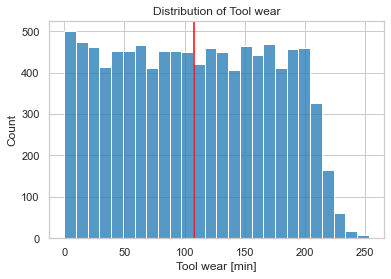

In [20]:
fig, ax = plt.subplots()
ax.set(title = "Distribution of Tool wear")
sn.histplot(data = maintenance_df,x="Tool wear [min]")
plt.axvline(x=maintenance_df["Tool wear [min]"].mean(), color = "red")
print("Minimum:", maintenance_df["Tool wear [min]"].min())
print("Maximum:", maintenance_df["Tool wear [min]"].max())
print("Mean:", maintenance_df["Tool wear [min]"].mean())
print("Standard deviation:", maintenance_df["Tool wear [min]"].std())

The tool wear ranges from 0 to 253 minutes. It is relatively equally distributed from 0 to 200 minutes with an average of 107 minutes, and there are fewer values above 200 minutes. 
This can also be observed in the following boxplot. 

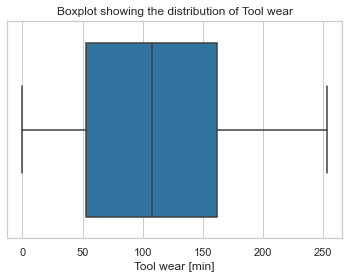

In [21]:
fig, ax = plt.subplots()
ax.set(title = "Boxplot showing the distribution of Tool wear")
sn.boxplot(data = maintenance_df,x="Tool wear [min]")
plt.show()

As you can see, the right whisker is longer than the left one, whereas the left whisker and two parts of the box are approximately the same size. 

### Target 1: Machine failure
The first target that I want to predict is whether the machine fails or not.

No machine failure: 9652 times.
Machine failure: 348 times.


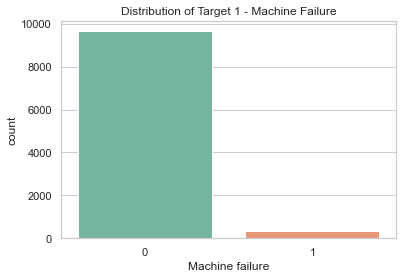

In [22]:
fig, ax = plt.subplots()
ax.set(title = "Distribution of Target 1 - Machine Failure")
sn.set_palette(sn.color_palette("Set2"))
sn.countplot(data=maintenance_df, x="Machine failure")
print("No machine failure:", maintenance_df[maintenance_df["Machine failure"] == 0]["Product ID"].size, "times.")
print("Machine failure:", maintenance_df[maintenance_df["Machine failure"] == 1]["Product ID"].size, "times.")

As you can see from the barchart, there is a machine failure in 339 out of 10000 cases. Therefore, the dataset is highly imbalanced. However, a failure rate of 3.39 % would be, according to the author of the paper, considered critical in mass-production. This fact has to be considered when training and evaluating the model. 

### Target 2: Failure type
The second target is the failure type. 

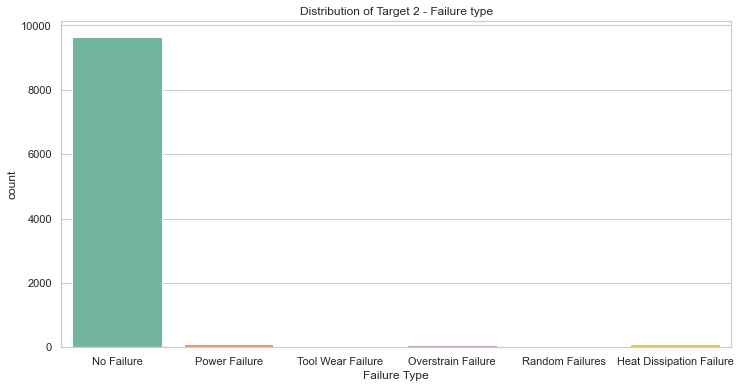

In [23]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set(title = "Distribution of Target 2 - Failure type")
sn.set_palette(sn.color_palette("Set2"))
sn.countplot(data=maintenance_df, x="Failure Type", ax=ax)
plt.show()

As could be expected from the previous results, the biggest failure type is "no failure". However, I want to inspect the "real" failure types more closely.

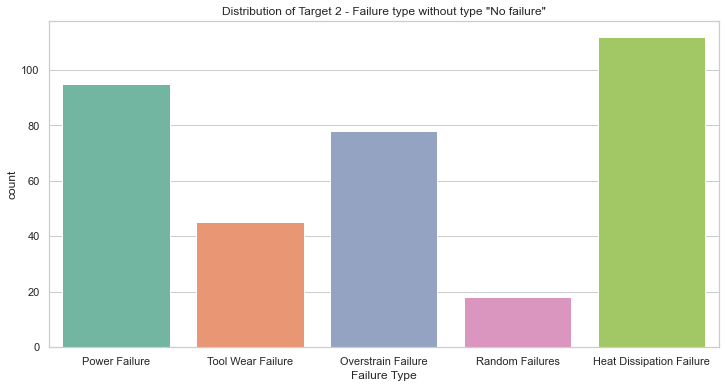

In [24]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set(title = "Distribution of Target 2 - Failure type without type \"No failure\"")
sn.set_palette(sn.color_palette("Set2"))
sn.countplot(data=maintenance_df[maintenance_df["Failure Type"] != "No Failure"], x="Failure Type", ax=ax)
plt.show()

Now one can see that the most common failure type is the "Heat Dissipation Failure", followed by "Power Failure" and "Overstrain Failure".

### Heatmap

The following Heatmap shows the correlation between the features. 

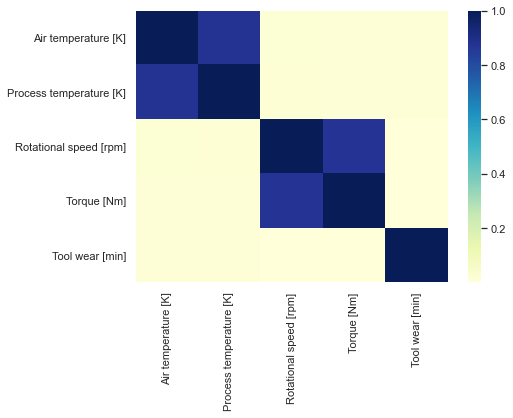

In [25]:
plt.figure(figsize=(7,5))
sn.heatmap(np.absolute(maintenance_df.loc[:, 'Product ID':'Tool wear [min]'].corr()), cmap="YlGnBu")
plt.show()

As you can see, most features are not correlated strongly. 
One exemption are the Torque and the Rotational speed. As described above, the Torque is the force that makes a part rotate, so it makes sense that these two features are highly correlated. 
Furthermore, the Air temperature and the Process temperature are highly correlated. This also makes sense from a physical viewpoint since the process can heat up the air around.

## Predicting Machine Failure with Classification Models 

In this chapter, I will train different classification models to predict the Machine Failure and the Failure Type. 
For each model, I will first use the Machine Failure (1 or 0) and then the Failure Type as a target. For the input variables I will use the features "Type", "Air temperature", "Process temperature", "Rotational speed", "Torque" and "Tool Wear". The features "UDI" and "Product ID" are unique, therefore they will not support the model. Furthermore, none of the targets should be used as features as this will lead to data leakage.

### Prepare the training and testing set
#### Encoding classes as numbers
First, I will encode the Failure Types as numbers. This is needed for feeding the data into a machine learning model.

In [26]:
encode=LabelEncoder()
maintenance_df.loc[:, maintenance_df.columns[-1]]=encode.fit_transform(maintenance_df.loc[:,maintenance_df.columns[-1]])
encode.classes_

array(['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure',
       'Power Failure', 'Random Failures', 'Tool Wear Failure'],
      dtype=object)

Now, the failure types are encoded as follows: 
* 0: Heat Dissipation Failure
* 1: No Failure
* 2: Overstrain Failure
* 3: Power Failure
* 4: Random Failures
* 5: Tool Wear Failure

Also the "Type" feature has to be encoded as numbers:

In [27]:
encode_2=LabelEncoder()
maintenance_df.loc[:, maintenance_df.columns[1]]=encode_2.fit_transform(maintenance_df.loc[:,maintenance_df.columns[1]])
encode_2.classes_

array(['H', 'L', 'M'], dtype=object)

Now the product quality types are encoded as follows: 
* 0: H
* 1: L
* 2: M

#### Split into training and testing set
Second, I will split the dataset into a training and testing dataset, which will be used to train and evaluate the classification algorithms. I use a test size of 30 %, as this is widely recommended amongst data scientists. 
For now, I split the dataset without separating the features into X and y. I will do this later because I will need to extract the two different targets ("Machine failure" and "Failure Type"). 

In [28]:
# Split the dataset into training and testing dataset 
df_train, df_test = train_test_split(maintenance_df, test_size = 0.3, random_state = 42)

As already described above, the dataset is highly imbalanced. Therefore, I will resample the training set. It is important not to resample the whole dataset, as these can lead to duplicates in the testing and training set. Then, the testing set would not be completely new to the model anymore and the model would experience data leakage.
I will 
* oversample the failure types "Power Failure", "Tool Wear Failure", "Overstrain Failure", "Random Failures" and "Heat Dissipation Failure" and
* subsample the failure type "No Failure".

While researching resampling techniques online, I came across two different strategies: 
* Subsample the majority class so that it contains 50 % of datapoints and oversample the minority class(es) so that they contain 50 % of datapoints as well 
* Subsample the majority class and oversample the minority classes so that all classes contain the same amount of datapoints

I will create two resampled training sets to try out both strategies. 

In [29]:
# split into majority and minority and inspect current ratio
df_split = []
for failure_type in range(0,6):
    if failure_type == 1:
        df_majority = df_train[df_train["Failure Type"]==failure_type]
    else: 
        df_split.append(df_train[df_train["Failure Type"]==failure_type])
        
        
length = 0
for i in range(0,5):
    length += len(df_split[i])

print("Current number of datapoints in training set:", len(df_train))
print("Current number of datapoints containing \"No failure\":", len(df_majority))
print("Current number of datapoints containing all other failure types:", length)



Current number of datapoints in training set: 7000
Current number of datapoints containing "No failure": 6749
Current number of datapoints containing all other failure types: 251


#### Resampling the training set - Strategy 1 (50 % failure, 50 % no failure)

In the following code block, I am using the resample function to subsample the class "no failure" and oversample the other failure types.

New number of datapoints in training set for strategy 1 : 7000
New number of datapoints containing "No failure" for strategy 1: 3500
New number of datapoints containing all other failure types for strategy 1: 3500


<AxesSubplot:xlabel='Failure Type', ylabel='count'>

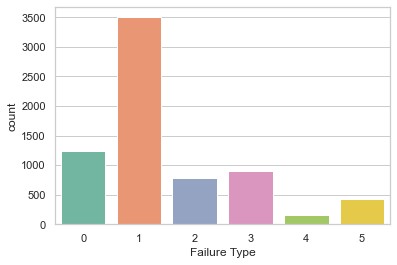

In [30]:
# Strategy 1: Oversample minority and undersample majority so that both contain 50 % of training datapoints
df_majority_resampled_1 = resample(df_majority, replace=True, n_samples = 3500)

df_split_resampled_1 = []

for i in range(0,5):
    df_split_resampled_1.append(resample(df_split[i], replace=True, n_samples = int(len(df_split[i])/length * 3500 + 0.6)))

length_resampled = 0
df_train_resampled_1 = df_majority_resampled_1
                                
for i in range(0,5):
    length_resampled += len(df_split_resampled_1[i])
    df_train_resampled_1 = pd.concat([df_train_resampled_1, df_split_resampled_1[i]])

print("New number of datapoints in training set for strategy 1 :", len(df_train_resampled_1))
print("New number of datapoints containing \"No failure\" for strategy 1:", len(df_majority_resampled_1))
print("New number of datapoints containing all other failure types for strategy 1:", length_resampled)
sn.countplot(data = df_train_resampled_1, x = "Failure Type")

As you can see above, I reached the goal of having 50 % "No Failure" and 50 % "Failure" datapoints in my training set. The plot shows additionally, that the other failure types are much better represented compared to before (refer to the chapter "Data Exploration" for a comparison). 

#### Resampling the training set - Strategy 2 (all failure classes are equally represented)

New number of datapoints in training set for strategy 1 : 6996
New number of datapoints in each failure class: 1166


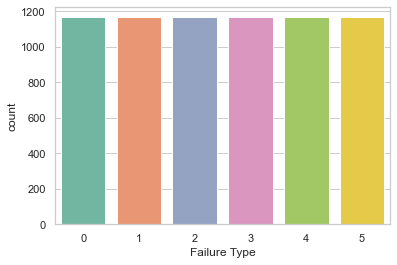

In [31]:
# Strategy 2: Oversample minority and undersample majority so that all classes are equally represented
df_majority_resampled_2 = resample(df_majority, replace=True, n_samples = int(7000//6))

df_split_resampled_2 = []

for i in range(0,5):
    df_split_resampled_2.append(resample(df_split[i], replace=True, n_samples = int(7000//6)))

length_resampled = 0
df_train_resampled_2 = df_majority_resampled_2
                                
for i in range(0,5):
    length_resampled += len(df_split_resampled_2[i])
    df_train_resampled_2 = pd.concat([df_train_resampled_2, df_split_resampled_2[i]])

print("New number of datapoints in training set for strategy 1 :", len(df_train_resampled_2))
print("New number of datapoints in each failure class:", int(7000//6))
sn.countplot(data = df_train_resampled_2, x = "Failure Type")
plt.show()

As you can see above, I reached the goal of representing each class equally in the training set. The plot shows this as well. 

#### Creating the X and y values for the testing set and the training sets
Now, we split the training sets and the testing set into the X values and the two different targets (y values).

In [32]:
# test set 
X_test = df_test.loc[:, 'Type':'Tool wear [min]']
y_test_b = df_test['Machine failure']
y_test_m = df_test['Failure Type']

# training set - strategy 1 
X_train_1 = df_train_resampled_1.loc[:, 'Type':'Tool wear [min]']
y_train_b_1 = df_train_resampled_1['Machine failure']
y_train_m_1 = df_train_resampled_1['Failure Type']


# training set - strategy 2
X_train_2 = df_train_resampled_2.loc[:, 'Type':'Tool wear [min]']
y_train_b_2 = df_train_resampled_2['Machine failure']
y_train_m_2 = df_train_resampled_2['Failure Type']

# variables for training sets 
X_train = [X_train_1, X_train_2]
y_train_b = [y_train_b_1, y_train_b_2]
y_train_m = [y_train_m_1, y_train_m_2]


### Choosing the best training set 
Before I will get into more detail regarding the classification models, I will determine which training set (strategy 1 or strategy 2) gives the better results. 
Therefore, I will try both training sets for each classifier (with standard hyperparameters) and plot the results of both training sets. Of course, this only serves as an estimate since none of the models is tuned and only the F1 score is used as a metric. However, if one training set clearly produces the better results, I will choose this one and use it to go into more detail and also tune the classification models.

In the following, I will use the F1 score as a metric. The F1 score is the harmonic mean of precision and recall. For imbalanced datasets, it is recommended to use the F1 score over the accuracy.   

In [33]:
classifiers = {"Dummy Classifier" : DummyClassifier(strategy = "most_frequent"), 
               "Decision Tree Classifier" : tree.DecisionTreeClassifier(random_state = 42), 
               "Random Forest Classifier" : RandomForestClassifier(n_estimators = 100, random_state = 42), 
               "K-Nearest-Neighbors Classifier" : KNeighborsClassifier(n_neighbors=5), 
               "Gaussian Naive Bayes Classifier" : GaussianNB()
              }

results_binary_1 = []
results_multiple_1 = []
results_binary_2 = []
results_multiple_2 = [] 

for classifier in classifiers:
    for i in range(0,2):
        clf = classifiers[classifier]
        clf.fit(X_train[i], y_train_b[i])
        y_pred_b = clf.predict(X_test)
        f1_score_b = f1_score(y_test_b, y_pred_b, average = 'weighted')
        clf.fit(X_train[i], y_train_m[i])
        y_pred_m = clf.predict(X_test)
        f1_score_m = f1_score(y_test_m, y_pred_m, average = 'weighted')
        if(i==0):
            results_binary_1.append(f1_score_b)
            results_multiple_1.append(f1_score_m)
        if(i==1):
            results_binary_2.append(f1_score_b)
            results_multiple_2.append(f1_score_m)

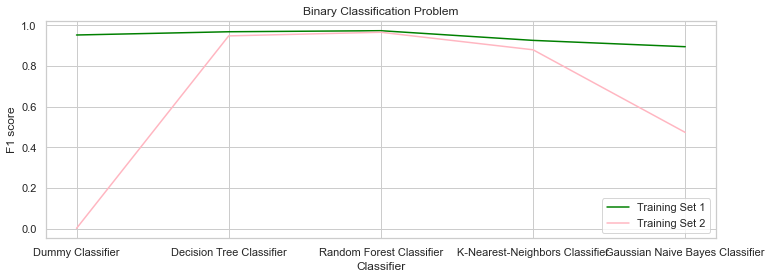

In [34]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)            
sn.lineplot(x=classifiers.keys(), y=results_binary_1, color = "green")
sn.lineplot(x=classifiers.keys(), y=results_binary_2, color = "lightpink") 
ax.set(title = "Binary Classification Problem", xlabel="Classifier", ylabel="F1 score")
plt.legend(labels=['Training Set 1', 'Training Set 2'])
plt.show()

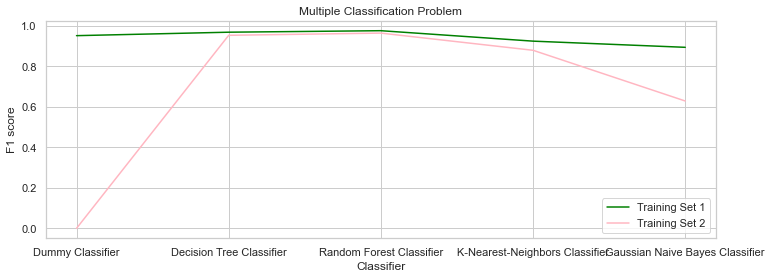

In [35]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)            
sn.lineplot(x=classifiers.keys(), y=results_multiple_1, color = "green")
sn.lineplot(x=classifiers.keys(), y=results_multiple_2, color = "lightpink") 
ax.set(title = "Multiple Classification Problem", xlabel="Classifier", ylabel="F1 score")
plt.legend(labels=['Training Set 1', 'Training Set 2'])
plt.show()

The plots show that Training Set 1 clearly produces the better results for both the binary and the multiple classification problem. Therefore, I will from now go on with the training set obtained with strategy 1 and rename the variables accordingly. Training Set 2 will be dropped.

In [36]:
X_train = X_train[0]
y_train_b = y_train_b[0]
y_train_m = y_train_m[0]

In the following, I will go into more detail regarding the classifiers and tune the classifiers. To later compare the performance of the models, I will save the obtained F1 scores and Recall scores in the lists I am creating in the following code block:

In [37]:
f1_scores_b = {}
f1_scores_m = {}
recall_scores_b = {}
recall_scores_m = {}

Furthermore, I create two functions that I can later use to obtain the f1 scores of each model: 

In [38]:
def evaluate_binary_f1(classifier):
    classifier.fit(X_train, y_train_b)
    y_pred_b = classifier.predict(X_test)
    f1_score_b = f1_score(y_test_b, y_pred_b, average = 'weighted')
    return f1_score_b

def evaluate_multiple_f1(classifier):
    classifier.fit(X_train, y_train_m)
    y_pred_m = classifier.predict(X_test)
    f1_score_m = f1_score(y_test_m, y_pred_m, average = 'weighted')
    return f1_score_m

I will do the same for the calculation of the recall score, which I will use as well to compare the models: 

In [39]:
def evaluate_binary_recall(classifier):
    classifier.fit(X_train, y_train_b)
    y_pred_b = classifier.predict(X_test)
    recall_score_b = recall_score(y_test_b, y_pred_b, average = 'weighted')
    return recall_score_b

def evaluate_multiple_recall(classifier):
    classifier.fit(X_train, y_train_m)
    y_pred_m = classifier.predict(X_test)
    recall_score_m = recall_score(y_test_m, y_pred_m, average = 'weighted')
    return recall_score_m

### Dummy Classifier
The first "model" that I will use is the Dummy Classifier. The Dummy Classifier simply predicts the most frequent class for every datapoint. Therefore, the accuracy of the Dummy Classifier equals the frequency of that class in the testing set. It serves as a benchmark accuracy score. Each "real" model should perform better than that to be helpful.

In [40]:
dummy_classifier = DummyClassifier(strategy = "most_frequent")

f1_score_b = evaluate_binary_f1(dummy_classifier)
recall_score_b = evaluate_binary_recall(dummy_classifier)
f1_scores_b["Dummy Classifier"]=f1_score_b
recall_scores_b["Dummy Classifier"]=recall_score_b
print("Dummy-F1-Score for binary classification problem: {0:.3f}%".format(100*f1_score_b))

f1_score_m = evaluate_multiple_f1(dummy_classifier)
recall_score_m = evaluate_multiple_recall(dummy_classifier)
f1_scores_m["Dummy Classifier"]=f1_score_m
recall_scores_m["Dummy Classifier"]=recall_score_m
print("Dummy-F1-Score for multiple classification problem: {0:.3f}%".format(100*f1_score_m))


Dummy-F1-Score for binary classification problem: 95.177%
Dummy-F1-Score for multiple classification problem: 95.177%


Since the biggest class for both classification problems is "No Failure", the dummy accuracy and the F1 scores are the same. 

### Decision Tree Classifier

A decision tree tries to predict the target using simple decision rules from the data features. The biggest advantage of a decision tree is that it is easily understandable by a human. The paper this dataset is from points out that for trusting a model, it is important that the user can interpret and understand it easily. However, decision trees are very unstable, because a small variation can result in a completely different decision tree. 

Parameters that these articles consider worth tuning: 
- max_depth
- min_samples_split (between 1 and 40) 
- min_samples_leaf 
- max_features

For the tuning of the Classifiers I wil use random search. Random search does not try every possible combination of features but selects at random to sample a wide range of values. It returns the best combination of hyperparameters.

#### F1 Score of the base model

Let's see what the base score for the decision tree classifier is. 

In [41]:
dectree_classifier = tree.DecisionTreeClassifier()

f1_score_b_base = evaluate_binary_f1(dectree_classifier)
f1_score_m_base = evaluate_multiple_f1(dectree_classifier)

print("F1 Score of basic Decision Tree Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_base * 100))
print("F1 Score of basic Decision Tree Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_base * 100))

F1 Score of basic Decision Tree Classifier for binary classification problem: 96.499%
F1 Score of basic Decision Tree Classifier for multiple classification problem: 96.933%


As you can see, the F1 scores of the Decision Tree Classifier are a little better than the dummy f1 scores. Still, I might be able to increase the score a bit more by tuning the model.

#### Tuning Decision Tree Classifier 
To use random search, I first have to create a parameter grid with the hyperparameter values I want to try out. For choosing the ranges, I will roughly orient myself on the standard parameters that can be found in the scikit learn documentation.

In [42]:
# Add the values I want to try out 
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = range(1,10)
min_samples_leaf = range(1,10)
max_features = ['sqrt', 'log2', None]

# Create the parameter grid
parameter_grid = {'max_depth': max_depth, 
                  'min_samples_split': min_samples_split,
                  'min_samples_leaf': min_samples_leaf,
                  'max_features': max_features}

print(parameter_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': range(1, 10), 'min_samples_leaf': range(1, 10), 'max_features': ['sqrt', 'log2', None]}


Now, I prepared the parameters I want to try out. Next, I will instantiate the random search (which is also a scikit-learn package) and fit it. To evaluate the parameter combination, the random search uses cross validation. In this case, I am using a 3-fold cross validation. This means that the algorithm splits the training data in three "parts" and trains the model only with two out of three parts. The third part will be used to validate the model. Then the algorithm repeats with another two out of three parts. Like that, overfitting can be avoided.

In [43]:
# instantiate base model (again just to be sure)
dectree_classifier = tree.DecisionTreeClassifier()
# Random search of parameters, using 3 fold cross validation, 
# try out 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = dectree_classifier, param_distributions = parameter_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Binary classification problem
rf_random.fit(X_train, y_train_b)
print("Optimized hyperparameters for binary classification problem for Decision Tree Classifier:")
print(rf_random.best_params_)
best_model_b = rf_random.best_estimator_

print("\n")
print("-" * 100)
print("\n")

# Multiple classification problem
rf_random.fit(X_train, y_train_m)
print("Optimized hyperparameters for multiple classification problem for Decision Tree Classifier:")
print(rf_random.best_params_)
best_model_m = rf_random.best_estimator_

Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 210 out of 225 | elapsed:    6.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Optimized hyperparameters for binary classification problem for Decision Tree Classifier:
{'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'log2', 'max_depth': 40}


----------------------------------------------------------------------------------------------------


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s


Optimized hyperparameters for multiple classification problem for Decision Tree Classifier:
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 80}


[Parallel(n_jobs=-1)]: Done 210 out of 225 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    1.3s finished


Since decision trees are rather unstable, the best hyperparameters vary every time I run the notebook. 
Still, it is visible that the ranges I chose for the parameters are fine: The optimized values are mostly in the middle of the ranges. For example, in this run, for the binary classification problem, the optimized hyperparameters were the following: 
* min_samples_split = 6 (range 1 to 10) 
* min_samples_leaf = 5 (range 1 to 10) 
* max_features = sqrt (no range given) 
* max_depth = 80 (range 10 to 100) 
If this was not the case, the ranges would have had to be adapted. 

So now let's see whether the optimized parameters give a better f1 score. 

In [44]:
f1_score_b_tuned = evaluate_binary_f1(best_model_b)
f1_score_m_tuned = evaluate_binary_f1(best_model_m)
print("F1 Score of tuned Decision Tree Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_tuned * 100))
print("F1 Score of tuned Decision Tree Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_tuned * 100))

print ("-" * 100)

print("Differences between F1 Scores for Base Model and Tuned Model for Random Forest Classifier:")
print("Binary Classification Problem: {0:.3f}%".format((f1_score_b_tuned - f1_score_b_base)*100))
print("Multiple Classification Problem: {0:.3f}%".format((f1_score_m_tuned - f1_score_m_base)*100))


F1 Score of tuned Decision Tree Classifier for binary classification problem: 94.463%
F1 Score of tuned Decision Tree Classifier for multiple classification problem: 96.732%
----------------------------------------------------------------------------------------------------
Differences between F1 Scores for Base Model and Tuned Model for Random Forest Classifier:
Binary Classification Problem: -2.035%
Multiple Classification Problem: -0.201%


Unfortunately, the tuned model does not result in a stable better performance. The instability of decision trees causes a large variety in the computed optimums. As already described above, everytime the code block is run, it calculates different values for the hyperparameters. Therefore, I will stick to the default parameters.

In [45]:
f1_scores_b["Decision Tree Classifier"]= f1_score_b_base
f1_scores_m["Decision Tree Classifier"]= f1_score_m_base

recall_scores_b["Decision Tree Classifier"]= evaluate_binary_recall(dectree_classifier)
recall_scores_m["Decision Tree Classifier"]= evaluate_multiple_recall(dectree_classifier)

### Random Forest Classifier 
According to the skicit learn documentation, a random forest is a meta estimator that fits a number of decision tree classifiers on sub-samples of the dataset and averages the results to improve the accuracy and control over-fitting. 
Therefore, it could be seen as an extension of a decision trees - it simply uses multiple decision trees and averages the result. Therefore, it is more stable than a single decision tree. 

The random forest classifier has more hyperparameters that are worth tuning than the decision tree. 
Common hyperparameters that are being tuned are: 
- n_estimators (the number of trees in the forest) 
- max_features (the number of features to consider when looking for the best split) 
- max_depth (the maximum depth of the tree) 
- min_samples_split (the minimum number of samples required to split an internal node) 
- min_samples_leaf (the minimum number of samples required to be at a leaf node) 
- bootstrap (the method of sampling datapoints - whether the whole dataset is used to build each tree or not)


Again, I will use random search to tune the Random Forest Classifier.

#### F1 Score of the Base Model

In [46]:
randforest_classifier = RandomForestClassifier()

f1_score_b_base = evaluate_binary_f1(randforest_classifier) 
f1_score_m_base = evaluate_multiple_f1(randforest_classifier) 

print("F1 Score of base Random Forest Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_base * 100))
print("F1 Score of base Random Forest Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_base * 100))

F1 Score of base Random Forest Classifier for binary classification problem: 97.473%
F1 Score of base Random Forest Classifier for multiple classification problem: 97.533%


As you can see, the F1 score of the basic (untuned) Random Forest Classifier is already better than the score of the Decision Tree Classifier. Furthermore, the results are much more stable than with the Decision Tree Classifier (when I run the code again, there are similar results). 

However, maybe I can improve the score a little bit with the tuning. 

#### Tuning Random Forest Classifier
For the values of the parameters, I again look at the standard hyperparameters provided by scikit learn. Additionally, I considered this article: 
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74 

In [47]:
# Add the values I want to try out 
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
min_samples_split = [2, 3, 5, 7, 9, 11, 13, 15]
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False] 

# Create the parameter grid
parameter_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(parameter_grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 3, 5, 7, 9, 11, 13, 15], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}


Again, using random search with cross validation (just as with the decision tree), I am trying to find the best hyperparameters for the Random Forest Classifier. 

In [48]:
# instantiate base model (again)
randforest_classifier = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# try out 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = randforest_classifier, param_distributions = parameter_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Binary classification problem
rf_random.fit(X_train, y_train_b)
print("Optimized hyperparameters for binary classification problem for Random Forest Classifier:")
print(rf_random.best_params_)
best_model_b = rf_random.best_estimator_

print("\n")
print("-" * 100)
print("\n")

# Multiple classification problem
rf_random.fit(X_train, y_train_m)
print("Optimized hyperparameters for multiple classification problem for Random Forest Classifier:")
print(rf_random.best_params_)
best_model_m = rf_random.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  3.8min finished


Optimized hyperparameters for binary classification problem for Random Forest Classifier:
{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': False}


----------------------------------------------------------------------------------------------------


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  4.0min finished


Optimized hyperparameters for multiple classification problem for Random Forest Classifier:
{'n_estimators': 800, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 80, 'bootstrap': False}


Again, the ranges I chose for the parameters seem to be fine. 
In this run, the optimized hyperparameters for the binary classification problem are as follows: 

* n_estimators = 400 (range 200 to 1000) 
* min_samples_split = 8 (range 2 to 15) 
* min_samples_leaf = 6 (range 1 to 8) 
* max_features = sqrt (no range) 
* max_depth = 30 (range 10 to 100 plus None) 
* bootstrap = False (no range) 

In [49]:
f1_score_b_tuned = evaluate_binary_f1(best_model_b)
f1_score_m_tuned = evaluate_multiple_f1(best_model_m)
print("F1 Score of tuned Random Forest Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_tuned * 100))
print("F1 Score of tuned Random Forest Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_tuned * 100))

print ("-" * 100)

print("F1 Score of base Random Forest Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_base * 100))
print("F1 Score of base Random Forest Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_base * 100))

print ("-" * 100)

print("Improvement for Tuned Model (Random Forest Classifier):")
print("Binary Classification Problem: {0:.3f}%".format((f1_score_b_tuned - f1_score_b_base)*100))
print("Multiple Classification Problem: {0:.3f}%".format((f1_score_m_tuned - f1_score_m_base) *100))


F1 Score of tuned Random Forest Classifier for binary classification problem: 97.553%
F1 Score of tuned Random Forest Classifier for multiple classification problem: 97.750%
----------------------------------------------------------------------------------------------------
F1 Score of base Random Forest Classifier for binary classification problem: 97.473%
F1 Score of base Random Forest Classifier for multiple classification problem: 97.533%
----------------------------------------------------------------------------------------------------
Improvement for Tuned Model (Random Forest Classifier):
Binary Classification Problem: 0.080%
Multiple Classification Problem: 0.216%


The F1 Scores of the tuned Random Forest Classifier are approximately the same as the scores obtained with the default values. In the runs that I did, the tuned score for the binary classification problem was slightly worse than the base score, whereas the tuned score for the multiple classification problem was sligthly better than the base score. That is why I will use the base score for the binary classification problem and the tuned score for the multiple classification problem. However, again, there was no significant improvement with tuning!

In [50]:
f1_scores_b["Random Forest Classifier"]= f1_score_b_base
f1_scores_m["Random Forest Classifier"]= f1_score_m_tuned

recall_scores_b["Random Forest Classifier"]= evaluate_binary_recall(randforest_classifier)
recall_scores_m["Random Forest Classifier"]= evaluate_multiple_recall(best_model_m)

### Naive Bayes
The Naive Bayes algorithm is an algorithm based on Bayes Theorem. 
The algorithm assumes that the features are independent of each other. This is the case in this dataset since the features have been synthetically developed. 
Furthermore, there are several types of Naive Bayes algorithms. Each algorithm assumes a different type of dataset. Theoretically, it is possible to apply the following Naive Bayes algorithms to this dataset.  
* Gaussian Naive Bayes (the algorithm assumes that the values are sampled from a gaussian distribution)
* Multinomial Naive Bayes (Usually used for document classification, it uses the frequency of words present in a document, for discrete values) 
* Complement Naive Bayes (An adaptation of the Multinomial Naive Bayes - but better for imbalanced datasets) 
* Bernoulli Naive Bayes (Assumes boolean variables) 

Probably, the only algorithm that makes sense for our dataset is the Gaussian Naive Bayes since most features (very roughly) have a gaussian distribution. 
Still, I will try all four algorithms to check the performance. 

Tuning the Naive Bayes algorithm, according to several articles, does not to improve the performance. 

In [51]:
nb_classifiers = {'Gaussian': GaussianNB(), 
               'Multinomial': MultinomialNB(), 
               'Complement': ComplementNB(), 
               'Bernoulli': BernoulliNB()}

nb_f1_b = []
nb_f1_m = []

for classifier in nb_classifiers: 
    clf = nb_classifiers[classifier]
    f1_score_b = evaluate_binary_f1(clf)
    nb_f1_b.append(f1_score_b)
    f1_score_m = evaluate_multiple_f1(clf)
    nb_f1_m.append(f1_score_m)
    print(classifier, "NaiveBayes-Accuracy for binary Classification problem: {0:.3f}%".format(f1_score_b * 100))
    print(classifier, "NaiveBayes-Accuracy for multiple Classification problem: {0:.3f}%".format(f1_score_m * 100))
    print("-" * 100)

Gaussian NaiveBayes-Accuracy for binary Classification problem: 89.422%
Gaussian NaiveBayes-Accuracy for multiple Classification problem: 89.418%
----------------------------------------------------------------------------------------------------
Multinomial NaiveBayes-Accuracy for binary Classification problem: 72.816%
Multinomial NaiveBayes-Accuracy for multiple Classification problem: 42.039%
----------------------------------------------------------------------------------------------------
Complement NaiveBayes-Accuracy for binary Classification problem: 72.816%
Complement NaiveBayes-Accuracy for multiple Classification problem: 73.733%
----------------------------------------------------------------------------------------------------
Bernoulli NaiveBayes-Accuracy for binary Classification problem: 18.872%
Bernoulli NaiveBayes-Accuracy for multiple Classification problem: 95.177%
----------------------------------------------------------------------------------------------------


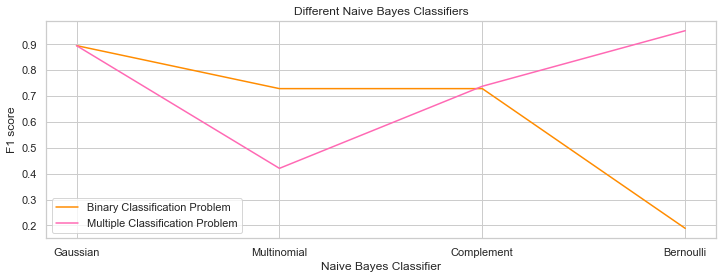

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)            
sn.lineplot(x=nb_classifiers.keys(), y=nb_f1_b, color = "darkorange")
sn.lineplot(x=nb_classifiers.keys(), y=nb_f1_m, color = "hotpink")
ax.set(title = "Different Naive Bayes Classifiers", xlabel="Naive Bayes Classifier", ylabel="F1 score")
plt.legend(labels=['Binary Classification Problem', 'Multiple Classification Problem'])
plt.show()

For the binary classification problem, the best performance occurs (as expected) with the Gaussian Naive Bayes algorithm. 
However, for some reason, for the multiple classification problem, the Bernoulli Naive Bayes algorithm performs best. I did some research on why this could be the case but was not able to find an explanation. The Bernoulli Naive Bayes Classifier is popularly used for classifying short texts, which (from my understanding) does not resemble the machine learning problem in this project a lot.

In [53]:
# Gaussian NB for binary classification
f1_scores_b["Naive Bayes Classifier"]= evaluate_binary_f1(GaussianNB())
recall_scores_b["Naive Bayes Classifier"]= evaluate_binary_recall(GaussianNB())

# Bernoulli NB for multiple classification
f1_scores_m["Naive Bayes Classifier"]= evaluate_multiple_f1(BernoulliNB())
recall_scores_m["Naive Bayes Classifier"]= evaluate_multiple_recall(BernoulliNB())

### K-Nearest Neighbors
The K-Nearest Neighbors tries to determine the class of a datapoint by looking at the k nearest neighbors (as the name already sais).

Hyperparameters that are worth tuning: 
* leaf_size: The K-Nearest Neighbor model chooses automatically an algorithm to compute the nearest neighbors. Some of these algorithms are trees. This parameter represents the leaf size passed to the algorithm) 
* n_neighbors: The number of neighbors to use 
* p: This is a parameter for the distance (Manhattan_distance for p = 1, Euclidian distance for p = 2, Minkowski distance for other values of p) 

#### F1 Score of the base model

In [54]:
knn_classifier = KNeighborsClassifier()
f1_score_b_base = evaluate_binary_f1(knn_classifier)
f1_score_m_base = evaluate_multiple_f1(knn_classifier)

print("F1 Score of base K-Nearest-Neighbor Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_base * 100))
print("F1 Score of base K-Nearest-Neighbor Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_base * 100))

F1 Score of base K-Nearest-Neighbor Classifier for binary classification problem: 92.532%
F1 Score of base K-Nearest-Neighbor Classifier for multiple classification problem: 92.466%


The performance of the base model is not very good. It is even worse than the dummy classifier. Let's see if this can be improved by tuning the K-Nearest Neighbor Classifier. 

#### Tuning K-Nearest Neighbors
For choosing the ranges, again, I will choose a range that contains the default parameters. 

In [55]:
# Add the values I want to try out 
leaf_size = range(1,50) # default-value 30
n_neighbors = range(1,30) # default-value 5
p = [1,2] # default-value 2

# Create the parameter grid
parameter_grid = {'leaf_size': leaf_size,
                  'n_neighbors': n_neighbors, 
                  'p': p}

print(parameter_grid)

{'leaf_size': range(1, 50), 'n_neighbors': range(1, 30), 'p': [1, 2]}


Again, using random search with cross validation (just as with the decision tree), I am trying to find the best hyperparameters for the K-Nearest Neighbor Classifier. 

In [56]:
# instantiate base model (again)
knn_classifier = KNeighborsClassifier()
# Random search of parameters, using 3 fold cross validation, 
# try out 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = knn_classifier, param_distributions = parameter_grid, n_iter = 75, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Binary classification problem
rf_random.fit(X_train, y_train_b)
print("Optimized hyperparameters for binary classification problem for K-Nearest Neighbor Classifier:")
print(rf_random.best_params_)
best_model_b = rf_random.best_estimator_

print("\n")
print("-" * 100)
print("\n")

# Multiple classification problem
rf_random.fit(X_train, y_train_m)
print("Optimized hyperparameters for multiple classification problem for K-Nearest Neighbor Classifier:")
print(rf_random.best_params_)
best_model_m = rf_random.best_estimator_


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    9.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Optimized hyperparameters for binary classification problem for K-Nearest Neighbor Classifier:
{'p': 2, 'n_neighbors': 1, 'leaf_size': 36}


----------------------------------------------------------------------------------------------------


Fitting 3 folds for each of 75 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s


Optimized hyperparameters for multiple classification problem for K-Nearest Neighbor Classifier:
{'p': 2, 'n_neighbors': 1, 'leaf_size': 36}


[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:    8.9s finished


The range of the parameters seems to be ok. 
For both classification problems (in this run), the optimized parameters are as follows: 

* p = 2 (this is the default value) 
* n_neighbors = 1 (range 1 to 30, 1 is the minimum value that is possible) 
* leaf_size = 36 (range 1 to 50) 


In [57]:
f1_score_b_tuned = evaluate_binary_f1(best_model_b)
f1_score_m_tuned = evaluate_multiple_f1(best_model_m)
print("F1 Score of tuned K-Nearest Neighbor Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_tuned * 100))
print("F1 Score of tuned K-Nearest Neighbor Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_tuned * 100))

print ("-" * 100)

print("F1 Score of base K-Nearest Neighbor Classifier for binary classification problem: {0:.3f}%".format(f1_score_b_base * 100))
print("F1 Score of base K-Nearest Neighbor Classifier for multiple classification problem: {0:.3f}%".format(f1_score_m_base * 100))

print ("-" * 100)

print("Differences between F1 Scores for Base Model and Tuned Model for K-Nearest Neighbor Classifier:")
print("Binary Classification Problem: {0:.3f}%".format((f1_score_b_tuned - f1_score_b_base)*100))
print("Multiple Classification Problem: {0:.3f}%".format((f1_score_m_tuned - f1_score_m_base)*100))


F1 Score of tuned K-Nearest Neighbor Classifier for binary classification problem: 94.736%
F1 Score of tuned K-Nearest Neighbor Classifier for multiple classification problem: 94.705%
----------------------------------------------------------------------------------------------------
F1 Score of base K-Nearest Neighbor Classifier for binary classification problem: 92.532%
F1 Score of base K-Nearest Neighbor Classifier for multiple classification problem: 92.466%
----------------------------------------------------------------------------------------------------
Differences between F1 Scores for Base Model and Tuned Model for K-Nearest Neighbor Classifier:
Binary Classification Problem: 2.204%
Multiple Classification Problem: 2.239%


For the K-Nearest-Neighbor Classifier I was able to reach a significant improvement. Unfortunately, the result is still worse than the result of the Dummy Classifier.
The improvement is probably due to the "n_neighbors" hyperparameter, which is lower than the default value. 
The optimization resulted that the default "p" hyperparameter gives the best results. The default parameter sets that the euclidian distance is used for calculating the distance between two datapoints. 
The value of *36* for the "leaf_size" hyperparameter is pretty close to the default value of *30*. 

In [58]:
f1_scores_b["K-Nearest Neighbor Classifier"]= f1_score_b_tuned
f1_scores_m["K-Nearest Neighbor Classifier"]= f1_score_m_tuned

recall_scores_b["K-Nearest Neighbor Classifier"]= evaluate_binary_recall(best_model_b)
recall_scores_m["K-Nearest Neighbor Classifier"]= evaluate_binary_recall(best_model_m)

## Evaluating the models

For evaluating the models I am using the F1 score (as already stated above), because the F1 score serves as a better metric for imbalanced datasets. Furthermore, I am comparing the Recall scores of the model. In predictive maintenance, a machine that fails although the algorithm predicted it would not (false negative) is a much bigger problem than an unnecessary check of a machine that actually wouldn't have failed (false positive). Therefore, the "Recall" metric is more important than the "Precision" metric. 

### F1-Scores

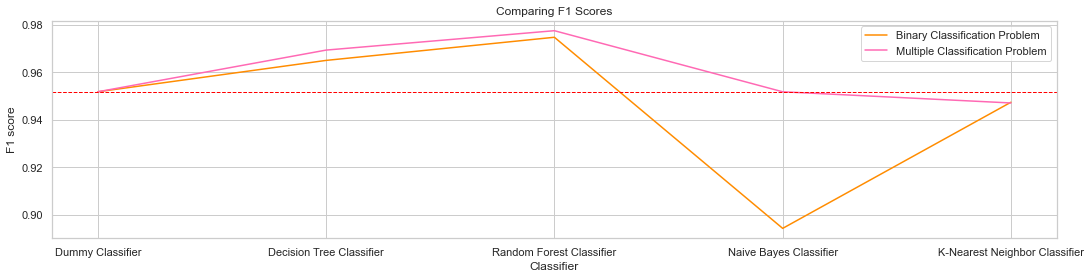

In [59]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)            
sn.lineplot(x=f1_scores_b.keys(), y=f1_scores_b.values(), color = "darkorange")
sn.lineplot(x=f1_scores_m.keys(), y=f1_scores_m.values(), color = "hotpink") 
ax.set(title = "Comparing F1 Scores", xlabel="Classifier", ylabel="F1 score")
plt.legend(labels=['Binary Classification Problem', 'Multiple Classification Problem'])
plt.axhline(f1_scores_b['Dummy Classifier'], color = "red", linestyle = "--", linewidth = 1)
plt.show()

As you can see, the Random Forest Classifier clearly gives the best F1 scores. However, on the other hand, the computing time for tuning the Random Forest was much higher than for the other models (about 12 minutes in comparison to few seconds for the other models). The Decision Tree Classifier, for instance, is much easier and faster to tune. It also has a higher F1 score than the Dummy Classifier (the red line indicates the F1 score of the Dummy Classifier). 
The Naive Bayes Classifier performs just as well as the Dummy Classifier for the multiple classification problem, but much worse for the binary classification problem. This is interesting, since the Naive Bayes Classifier is (in general) equally suited for binary and multiple classification problems. 
The K-Nearest Neighbors model performance is worse than the one of the Dummy Classifier, which might be an indication that the data is spread randomly (and therefore the neighbors of a datapoint do not give valuable information on the datapoint itself). 

### Recall Scores

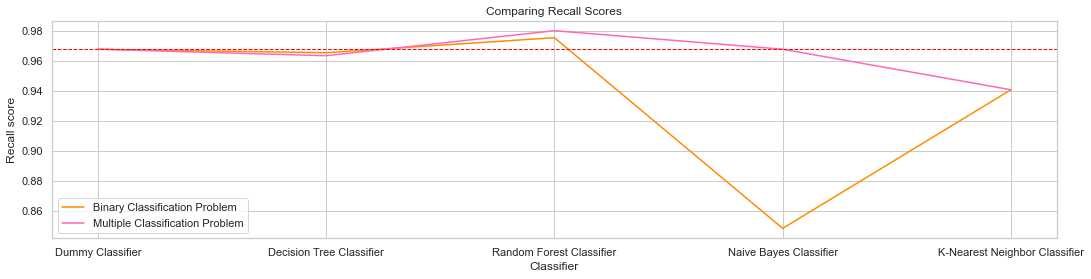

In [60]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 4)            
sn.lineplot(x=recall_scores_b.keys(), y=recall_scores_b.values(), color = "darkorange")
sn.lineplot(x=recall_scores_m.keys(), y=recall_scores_m.values(), color = "hotpink") 
ax.set(title = "Comparing Recall Scores", xlabel="Classifier", ylabel="Recall score")
plt.axhline(recall_scores_b['Dummy Classifier'], color = "red", linestyle = "--", linewidth = 1)
plt.legend(labels=['Binary Classification Problem', 'Multiple Classification Problem'])
plt.show()

For the recall scores, there is a mostly similar picture. Again, the Random Forest Classifier performs best. The K-Nearest Neighbor Classifier performs again (as expected) worse than the Dummy Classifier and the Naive Bayes Classifier performs equally for the multiple classification problem and worse for the binary classification problem. Only the Decision Tree Classifier now has a slightly worse score than the Dummy Classifier. So, apparently, the Decision Tree cannot recognize false negatives as well as false positives. 

# Conclusion

This project and the analyzed dataset cover a very interesting and recent technology: Predictive Maintenance. Predictive Maintenance is said to have a huge potential: Instead of repairing machines and other facilities after they break, parts can be exchanged even before they break. Like that, a stop in production or service can be avoided, which certainly is a huge economic advantage. 

The gartner hype cycle of 2019 mentions Predictive Analytics (which Predictive Maintenance is part of). The gartner hype cycle indicates, in which phase of development a technology currently is. As you can see below in the picture, Predictive Analytics was (in 2019) already on its way to become an established technology. 

![title](https://emtemp.gcom.cloud/ngw/globalassets/en/newsroom/images/graphs/DA-BI-HC.png)

The synthetic dataset used in this project reduces the task of predictive maintenance to a classification problem with two targets. For predicting these two targets, the Random Forest Classifier prove to be most successful. For some real-world problems, for sure, a model like this is sufficient and will improve processes a lot. However, for the majority of Predictive Maintenance use cases, historical data will be used. This data usually consists of time series. For the analysis of time series, more advanced machine learning will be needed. Still, this project is a nice starting point in my eyes. 